In [1]:
import torch
import torch.nn as nn

import time

import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
data_path = '../data/'
prefix = 'aug'
full_data = torch.load(data_path + prefix + '_data_large.pt')
full_label = torch.load(data_path + prefix + '_label_large.pt')

full_size = full_data.size(0)


In [3]:
# data_path = '../data/'
# prefix = 'aug'
# full_data = torch.load(data_path + prefix + '_data_med.pt')
# full_label = torch.load(data_path + prefix + '_label_med.pt')

# full_size = full_data.size(0)



In [4]:
# TODO: split into training and testing 80%-20%
indices = torch.randperm(full_size)
train_size = int(full_size * 0.8)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = full_data[train_indices]
train_label = full_label[train_indices]
test_data = full_data[test_indices]
test_label = full_label[test_indices]

In [5]:
train_data = train_data / 255
test_data = test_data / 255

In [6]:
# show size
print("Training data, ", train_data.size(), "Type", train_data.type())
print("Training label,", train_label.size())



Training data,  torch.Size([24448, 3, 128, 128]) Type torch.FloatTensor
Training label, torch.Size([24448])


In [7]:
train_data.size()

torch.Size([24448, 3, 128, 128])

In [8]:
print(train_data.shape, train_label.shape)

torch.Size([24448, 3, 128, 128]) torch.Size([24448])


In [9]:
train_label

tensor([7, 2, 4,  ..., 6, 1, 0])

In [10]:
train_data_size = train_data.size(0)
print(train_data_size)
print(train_data.is_contiguous())

24448
True


## Utility Functions
- display num param
- show image

- get error
- evaluate on test data

In [11]:
# Util func
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

In [12]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')


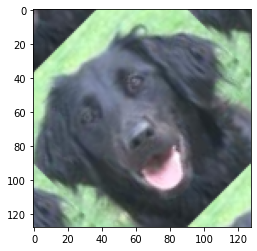

tensor(1)


In [13]:
show(train_data[78])
print(train_label[78])

In [14]:
def get_error( scores , labels ):
    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

In [15]:
def eval_on_test_set():

    test_size = test_data.size(0)
    running_error = 0
    num_batches = 0

    for i in range(0,(test_size//bs)*bs, bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        inputs = (minibatch_data - mean)/std

        scores = net(inputs) 

        error = get_error(scores, minibatch_label)

        running_error += error.item()

        num_batches += 1

    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 , 'percent')
    return total_error

## Build CNN
A VGG-liked CNN Structure

In [16]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 64 x 64 --> 64 x 32 x 32        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1)
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 32 x 32 --> 128 x 16 x 16
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 16 x 16 --> 256 x 8 x 8        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 8 x 8 --> 512 x 4 x 4
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 4 x 4 --> 512 x 2 x 2
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

        # dropout layer
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout(x)

        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)

        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        x = self.conv5a(x)
        x = torch.relu(x)
        x = self.pool5(x)
        x = self.dropout(x)

        x = x.contiguous()
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

#A larger network

In [51]:
class VGG_convnet_large(nn.Module):

    def __init__(self):

        super(VGG_convnet_large, self).__init__()

        # block 1:         3 x 128 x 128 --> 64 x 64 x 64        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1)
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 64 x 64 --> 128 x 32 x 32
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 32 x 32 --> 256 x 16 x 16        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 16 x 16 --> 512 x 8 x 8
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 8 x 8 --> 512 x 4 x 4
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5  = nn.MaxPool2d(2,2)

        self.linear1 = nn.Linear(512*4*4, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

        # dropout layer
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)
        # x = self.dropout(x)

        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)
        # x = self.dropout(x)

        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        x = self.conv5a(x)
        x = torch.relu(x)
        x = self.pool5(x)
        # x = self.dropout(x)

        x = x.contiguous()
        x = x.view(-1, 512*4*4)
        x = self.linear1(x)
        x = torch.relu(x)
        # x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

Try to implement a baseline Efficient Net (EfficientNet-B0) network

In [52]:
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.EfficientNetB4 = torchvision.models.efficientnet_b4(pretrained=False)
        self.EfficientNetB4 = self.EfficientNetB4.train()
        self.linear1 = nn.Linear(1000, 10)
    
    def forward(self, x):
        x = self.EfficientNetB4(x)
        x = nn.ReLU()(x)
        x = self.linear1(x)
        return x
        

In [53]:
import torchvision

# net = EfficientNet()
net = VGG_convnet_large()
print(net)
display_num_param(net)
# print(net.EfficientNetB4)

VGG_convnet_large(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (

In [54]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [55]:
mean = train_data.mean()

In [56]:
std = train_data.std()

In [57]:
net = net.to(device)

mean = mean.to(device)

std = std.to(device)

In [58]:
mean, std

(tensor(0.4381, device='cuda:0'), tensor(0.2672, device='cuda:0'))

##Define Early Stopping function

In [46]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time test error improved.
            verbose (bool): If True, prints a message for each test error improvement. 
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.        
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.test_err_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, test_err, model):

        score = -test_err

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(test_err, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            self.trace_func(f'Current Best Accuracy: {1 + self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(test_err, model)
            self.counter = 0

    def save_checkpoint(self, test_err, model):
        if self.verbose:
            self.trace_func(f'Test error decreased ({self.test_err_min:.6f} --> {test_err:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.test_err_min = test_err

## Define Hyper-parameters

In [59]:
from cutmix.utils import CutMixCrossEntropyLoss

criterion = nn.CrossEntropyLoss()
# criterion = CutMixCrossEntropyLoss(True)
optimizer=torch.optim.AdamW(net.parameters(), lr=1e-4)
bs = 25
patience = 12
epochs = 100

## Training

In [60]:
start=time.time()

early_stopping = EarlyStopping(patience=patience, verbose=True)

train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0
    running_error = 0
    num_batches = 0
    
    shuffled_indices=torch.randperm(train_data_size)
 
    for count in range(0, (train_data_size//bs)*bs, bs):
    
        optimizer.zero_grad()
         
        indices=shuffled_indices[count:count+bs]
        minibatch_data = train_data[indices]
        minibatch_label = train_label[indices]

        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std
        
        inputs.requires_grad_()

        scores = net(inputs) 

        loss = criterion(scores, minibatch_label) 
          
        loss.backward()

        optimizer.step()
    
        running_loss += loss.detach().item()
        
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    test_err = 0
    if epoch % 1 == 0:
        print('epoch=', epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 , 'percent')
        test_err = eval_on_test_set() 
        print(' ')
    
    
    early_stopping(test_err, net)
        
    if early_stopping.early_stop:
        print("Early stopping.....")
        break

# load the last checkpoint with the best model
net.load_state_dict(torch.load('checkpoint.pt'))

epoch= 0 	 time= 73.48355412483215 	 loss= 2.153343520852658 	 error= 81.52303069738429 percent
test error  =  77.9672142179286 percent
 
Test error decreased (inf --> 0.779672). Saving model...
epoch= 1 	 time= 152.5655550956726 	 loss= 2.0147668009770685 	 error= 74.3909937027411 percent
test error  =  71.13114837251726 percent
 
Test error decreased (0.779672 --> 0.711311). Saving model...
epoch= 2 	 time= 231.93406677246094 	 loss= 1.8527725806865867 	 error= 67.20573251176637 percent
test error  =  65.31147612411468 percent
 
Test error decreased (0.711311 --> 0.653115). Saving model...
epoch= 3 	 time= 311.2918949127197 	 loss= 1.6751573869125382 	 error= 60.09416640597942 percent
test error  =  58.29508263068121 percent
 
Test error decreased (0.653115 --> 0.582951). Saving model...
epoch= 4 	 time= 389.1699888706207 	 loss= 1.4503189773740153 	 error= 51.389969975335816 percent
test error  =  53.59016446793665 percent
 
Test error decreased (0.582951 --> 0.535902). Saving model

<All keys matched successfully>

In [ ]:
show(test_data[30])

#Show final result on test set

In [61]:
eval_on_test_set()

test error  =  39.65573902012872 percent


0.3965573902012872